Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Assignment)

This notebook is for you to practice skills during lecture.

Today's guided module project and assignment will be different. You already know how to do classification. You ready know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills.

## Sections
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy
* <a href="#p4">Part 4</a>: Post Lecture Assignment

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

### Load Competition Data

In [24]:
# Importing necessary modules.

import pandas as pd
import scipy.stats as stats
import seaborn as sns
sns.set()
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from explore_data import *

In [2]:
# Importing the kaggle data.

train = pd.read_csv('./whiskey-reviews-dspt4/train.csv')
test = pd.read_csv('./whiskey-reviews-dspt4/test.csv')
print(train.shape, test.shape)

(4087, 3) (1022, 2)


### Exploring the Data

In [3]:
# First peek at the data.

train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [4]:
# Get the median number of words per sample.

median_words_per_sample = get_num_words_per_sample(train['description'])
print(f'Median words per sample: {median_words_per_sample}')

Median words per sample: 70.0


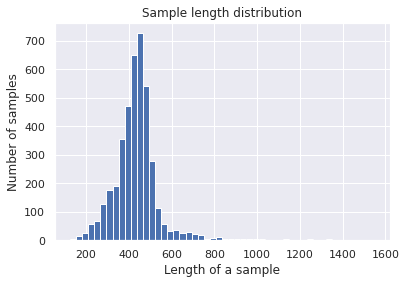

In [5]:
# Distribution of the review lengths - appears to be normal.

plot_sample_length_distribution(train['description'])

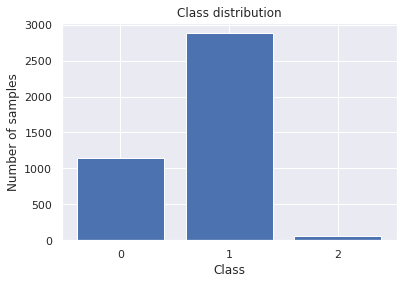

In [6]:
# Distribution of ratingCategory: 0 (Excellent), 1 (Good), 2 (Poor)
# There is very few poor category reviews.

plot_class_distribution(train['ratingCategory'])

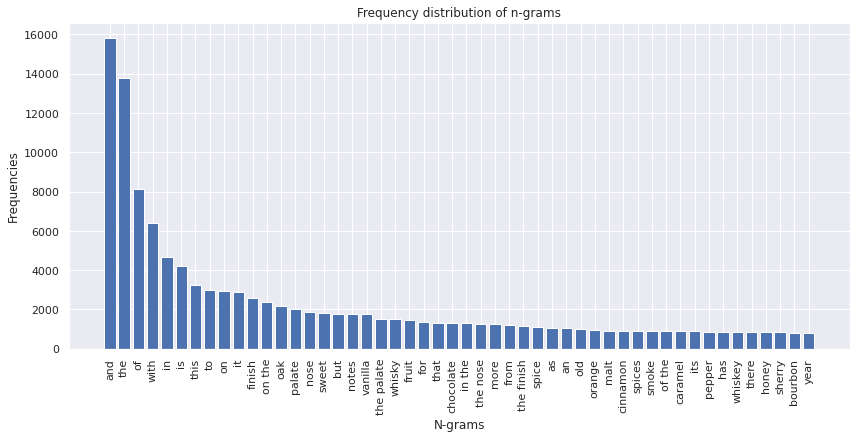

In [7]:
# Get a plot of 50 most used terms.
# Vanilla, fruit, chocolate, spice, orange, caramel, pepper and honey show what drinkers
# might look for in terms of flavor.

plot_frequency_distribution_of_ngrams(train['description'],
                                      ngram_range=(1, 2),
                                      num_ngrams=50)

In [8]:
# Read a few reviews from the "Excellent" category
pd.set_option('display.max_colwidth', 0)
train[train.ratingCategory == 0].sample(3)

,id,description,ratingCategory
2210,4126,"\nOriginally exclusive to the Swedish market, this expression was selected by Highland Park’s Danish brand ambassador Martin Markvardsen. Matured in a combination of 70% bourbon barrels and 30% oloroso sherry casks. Waxy and malty on the early nose, with fresh earth, damp moss, vanilla, and honey. Gentle peat on the palate, more earthy notes; herbal, with lime and salt. The finish is quite short, showing apricots, slight peatiness, allspice.",0
1131,4744,"\nDistilled from “bottle-ready IPA.” Sure is; the hops leap out of the glass, piney and pithy, a real west coast beer and whiskey experience in a glass. Quite a fat mouthfeel for 99 proof, a big oily thing that rolls around the tongue, making itself at home with flaring hop flavor — not really bitter — and an underlying sweetness. Bittering kicks in on the finish. An astonishing experience that really grows on you…but ultimately there’s a lack of depth. Price is per 1 liter.",0
113,4444,"\nThis single cask (#10328) bottling was distilled in the summer of 2006 and matured in a refill hogshead. The nose is initially slightly mashy, with savory notes, becoming more floral, with caramel. Bold and spicy on the palate, with roasted meat and underlying citrus fruit and herbal notes. Mildly metallic dark chocolate in the medium-length finish. £42",0


In [9]:
# Read a few reviews from the "Poor" category
train[train.ratingCategory == 2].sample(3)

,id,description,ratingCategory
1209,5092,"\nThe sherry is very dominant and cloying, which is unfortunate. And I’m not crazy about the quality of the sherry (or perhaps even the wood it was aged in). I have great respect for both Highland Park and Binny’s, but this is somewhat disappointing for a Highland Park. Tasted twice, with the same opinion. (Bottled for Binny’s Beverage Depot)",2
3289,5083,"\nThere are flavored—cinnamon and coconut—versions at lower proof; this is the “Original,” unflavored at full proof. Unaged and clear, the aroma is clean and full of roasted corn and a ripple of deep caramel. Surprisingly appealing, actually. Tastes like raw new make, though: green, feinty, vegetal, and crying out for cola, ginger ale, even Mountain Dew to help mask it. Are we done with ‘moonshine’ yet? Please?",2
769,5048,"\nDeep on the nose and heavy on the palate. Enjoyably perfumed aromas and an entertaining palate, with both showing a complex array of chewy toffee, cinnamon, candied fruit, roasted nuts, dusty cocoa, and tobacco. But a very tactile leather and oak resin component dominates mid-palate through to the finish, spoiling the party. It’s past its prime.\r\n",2


In [10]:
# Getting the S/W ratio to see what path should we take on the Google flowchart.

sw_ratio = len(train['description']) / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 58


### Split the Training Set into Train/Validation

In [12]:
# Split our train data into train, test portions.

X_train, X_test, y_train, y_test = train_test_split(train['description'],
                                                      train['ratingCategory'],
                                                      test_size=0.2,
                                                      stratify=train['ratingCategory'],
                                                      random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3269,) (818,) (3269,) (818,)


### Define Pipeline Components

In [17]:
# Create Pipeline Components

vect = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
rfc = RandomForestClassifier()

In [18]:
# Get sparse dtm

dtm = vect.fit_transform(X_train)

# Convert to dataframe

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(3269, 91347)

In [20]:
# Define the Pipeline

pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('clf', rfc)         # RandomForest Classifier
])

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [34]:
#parameters = {
#    'vect__max_df': (0.75, 1.0),
#    'clf__max_depth':(5,10,15,20)
#}

parameters = {
    'vect__max_df': (0.5, 0.7, 1.0),
    'vect__min_df': (2, 5, 10),
    'vect__max_features': (5000, 20000),
    'clf__n_estimators': (100, 250, 500),
    'clf__max_depth': (10, 20, None),
    'clf__min_samples_split': (2, 5, 10),
    'clf__min_samples_leaf': (1, 2, 3),    
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  30 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-3)]: Done 180 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-3)]: Done 430 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-3)]: Done 780 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-3)]: Done 1230 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-3)]: Done 1780 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-3)]: Done 2430 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-3)]: Done 3180 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-3)]: Done 4030 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-3)]: Done 4980 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-3)]: Done 6030 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-3)]: Done 7180 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-3)]: Done 7290 out of 7290 | elapsed: 26.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(2, 2),
                                                        no

In [36]:
grid_search.best_score_

0.7188750111225068

In [37]:
grid_search.best_params_

{'clf__max_depth': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 5,
 'clf__n_estimators': 250,
 'vect__max_df': 1.0,
 'vect__max_features': 20000,
 'vect__min_df': 2}

In [38]:
# Evaluate on test data

y_actual = grid_search.predict(X_test)
accuracy_score(y_test, y_actual)

0.6980440097799511

### Make a Submission File
*Note:* In a typical Kaggle competition, you are only allowed two submissions a day, so you only submit if you feel you cannot achieve higher test accuracy. For this competition the max daily submissions are capped at **20**. Submit for each demo and for your assignment. 

In [26]:
# Predictions on test sample
pred = grid_search.predict(test['description'])

In [27]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [28]:
# Make Sure the Category is an Integer
submission.head()

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1


In [29]:
subNumber = 0

In [33]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt4/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

You're trying to achieve a minimum of 70% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Follow Along
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
4. Make a submission to Kaggle 


### Define Pipeline Components

In [ ]:
# Use parameters from GridSearch in previous section
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1,2),
                       min_df=2, 
                       max_df=1.0,
                       max_features=5000)

# Add dimensionality reduction
svd = TruncatedSVD(algorithm='randomized',
                   n_iter=10)

# Use parameters from RandomSearch in previous section
rfc = RandomForestClassifier(n_estimators=500, 
                             random_state=42)

In [ ]:
params = {
    'svd__n_components': stats.randint(100, 500),
}

In [ ]:
pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('svd', svd),        # Truncated SVD Dimensionality Reduction
    ('clf', rfc)         # RandomForest Classifier
])

In [ ]:
# Fit
random_search = RandomizedSearchCV(pipe, params, cv=2, n_iter=3, n_jobs=-2, verbose=1)
random_search.fit(X_train, y_train)

In [ ]:
random_search.best_score_

In [ ]:
random_search.best_params_

In [ ]:
# Evaluate on test data

y_test = random_search.predict(X_test)
accuracy_score(y_test_o, y_test)

### Define Your Search Space
You're looking for both the best hyperparameters of your vectorizer and your classification model. 

In [ ]:
parameters = {
    'lsi__svd__n_components': [10,100,250],
    'vect__max_df': (0.75, 1.0),
    'clf__max_depth':(5,10,15,20)
}

grid_search = GridSearchCV(pipe,parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(..., ...)

### Make a Submission File

In [ ]:
# Predictions on test sample
pred = grid_search.predict(test['description'])

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [ ]:
# Make Sure the Category is an Integer
submission.head()

In [ ]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model

submission.to_csv(f'./whiskey-reviews-dspt4/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

## Follow Along

In [ ]:
# Apply to your Dataset
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint

param_dist = {
    'max_depth' : randint(3,10),
    'min_samples_leaf': randint(2,15)
}

In [ ]:
# Continue Word Embedding Work Here

### Make a Submission File

In [ ]:
# Predictions on test sample
pred = ...predict(test['description'])

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'ratingCategory':pred})
submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

In [ ]:
# Make Sure the Category is an Integer
submission.head()

In [ ]:
# Save your Submission File
# Best to Use an Integer or Timestamp for different versions of your model
submission.to_csv(f'./whiskey-reviews-dspt4/submission{subNumber}.csv', index=False)
subNumber += 1

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Post Lecture Assignment
<a id="p4"></a>

Your primary assignment this afternoon is to achieve a minimum of 70% accuracy on the Kaggle competition. Once you have achieved 70% accuracy, please work on the following: 

1. Research "Sentiment Analysis". Provide answers in markdown to the following questions: 
    - What is "Sentiment Analysis"? 
    - Is Document Classification different than "Sentiment Analysis"? Provide evidence for your response
    - How do create labeled sentiment data? Are those labels really sentiment?
    - What are common applications of sentiment analysis?
2. Research our why word embeddings worked better for the lecture notebook than on the whiskey competition.
    - This [text classification documentation](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) from Google might be of interest
    - Neural Networks are becoming more popular for document classification. Why is that the case?